In [48]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
from dateutil.parser import parse
from sf import getFilename

%matplotlib inline

- matplotlib plotting params:

In [2]:
font = {
    'family': 'Verdana',
    'weight': '300',
    'size': 12
}

rc('font', **font)

## Utils

In [49]:
def extract_task_value(task_index, row):
    try:
        return row[task_index]['value']
    except: 
        return
    
def parse_time(string):
    return pd.Timestamp(parse(string))

def percentageVotesForAnswer(counts, answer):
    '''
    `counts` is a df column like {galaxy: 15, group of objects (cluster): 10, something else/empty center: 2}
    `answer` is one of the keys of counts
    '''
    
    totalVotes = sum(counts.values())
    
    if not answer in counts.keys():
        return 0
    
    votesForAnswer = counts[answer]
    
    return round(100*votesForAnswer/totalVotes, 1)

---

---

- Load and inspect the dataframe.
- Parse stringified columns.
- Remove rows where the user didn't make a classification.

In [4]:
# load dataframe
df = pd.read_csv('../SpaceFluff/zooniverse_exports/classify-classifications.csv', delimiter=",")

# inspect column names
print(df.keys())

# JSON parse the columns that were stringified
columns_to_parse = ['annotations', 'subject_data', 'metadata']

for column in columns_to_parse:
    df[column] = df[column].apply(json.loads)
    
# extract filename, task0 and task1 values to new dataframe columns
df['Filename'] = df['subject_data'].apply(getFilename)
df['Task0'] = df['annotations'].apply(lambda x: extract_task_value(0, x))
df['Task1'] = df['annotations'].apply(lambda x: extract_task_value(1, x))

# finally, remove all rows where task0 wasn't answered (because the row, then, is useless)
df = df[~df['Task0'].isnull()]

Index(['classification_id', 'user_name', 'user_id', 'user_ip', 'workflow_id',
       'workflow_name', 'workflow_version', 'created_at', 'gold_standard',
       'expert', 'metadata', 'annotations', 'subject_data', 'subject_ids'],
      dtype='object')


- Remove 'retired' rows. 
<div style="color: orangered"><strong>Q: Why didn't the object simply get taken out of the rotation once 'retired'?</strong></div>

To eliminate 'retired' entries and 'already seen entries':
- extract subject_selection_state metadata, which contains both `retired` and `already_seen` fields
- filter out entries where either `retired` or `already_seen` is true

In [5]:
# create temporary isRetired and alreadySeen rows
df['isRetired'] = df['metadata'].apply(lambda x: x['subject_selection_state']['retired'])
df['alreadySeen'] = df['metadata'].apply(lambda x: x['subject_selection_state']['already_seen'])

# remove rows where isRetired or alreadySeen
df = df[~df['isRetired'] & ~df['alreadySeen']]

# remove isRetired and alreadySeen columns since they're obsolete hereafter
df.drop(['isRetired', 'alreadySeen'], axis=1, inplace=True)

## Goal of this notebook:

- For every unique object in the dataset, extract the following fields:
    - name,
    - 'task 0' value (recall 'task 0' asks if the users sees a galaxy or a group of objects
    - @todo: 'task 1' value if it exists

In [6]:
# extract unique object names that resulted from another notebook 
candidate_names_classify = np.loadtxt('./sf_objectImageStrings__classification-classify.txt', dtype=str)

In [7]:
# group df by filename, so that each group contains only rows belonging to that object
gr = df.groupby('Filename')

# create empty list to push results to
task0Values = []

In [8]:
# loop over every group created above to accumulate 'task 0' votes ('galaxy'/'group of objects'/'something else')
for objectName in candidate_names_classify:
    task0 = gr.get_group(objectName)['Task0']
    
    counts = task0.value_counts().to_dict()
    
    countObj = {
        "name": objectName,
        "counts": counts,
    }
    
    task0Values.append(countObj)

In [9]:
df_task0 = pd.DataFrame(task0Values)
df_task0.head()

,name,counts
0,UDGcand_1541_insp.png,{'Galaxy': 15}
1,UDGcand_5603_insp.png,"{'Group of objects (Cluster)': 11, 'Galaxy': 4}"
2,UDGcand_6077_insp.png,{'Group of objects (Cluster)': 17}
3,UDGcand_5840_insp.png,{'Something else/empty center': 14}
4,UDGcand_5600_insp.png,{'Something else/empty center': 16}


In [10]:
answer_types = ['Galaxy', 'Group of objects (Cluster)', 'Something else/empty center']

df_task0['# votes'] = df_task0['counts'].apply(lambda x: sum(x.values()))

for ans_type in answer_types:
    vote_percentage_column = df_task0['counts'].apply(lambda x: percentageVotesForAnswer(x, ans_type))
    df_task0['% votes {}'.format(ans_type)] = vote_percentage_column

---
---

In [11]:
# rough initial separation just for inspection
mostly_something = df_task0[df_task0['% votes Galaxy'] > 50]
mostly_nothing = df_task0[df_task0['% votes Something else/empty center'] > 50]

# strip the image extension from the names
mostly_nothing = list(map(lambda x: x[:-9], list(mostly_nothing['name'])))
mostly_something = list(map(lambda x: x[:-9], list(mostly_something['name'])))

In [12]:
# extract catalogue targets from other notebook
ct = np.loadtxt('../catalogue/sf_catalogue_targets.txt', dtype='str')

# differing: objects in the catalogue that people mostly vote 'something else' on
difference = list(set(ct) & set(mostly_nothing))

# corresponding: objects in the catalogue that people mostly vote 'galaxy'/'cluster' on
intersection = list(set(ct) & set(mostly_something))

In [13]:
print(len(difference), len(intersection))

len(ct) - len(difference) - len(intersection)

95 80


90

In [14]:
remaining_objects = np.setdiff1d(np.setdiff1d(ct, difference), intersection)

In [15]:
# slice df_task0 to see votes for objects that are included in the catalogue as potential UDGs
df_task0['name'] = df_task0['name'].apply(lambda x: x[:-9])
df_task0[df_task0['name'].isin(remaining_objects)]

,name,counts,# votes,% votes Galaxy,% votes Group of objects (Cluster),% votes Something else/empty center
79,UDGcand_5044,"{'Galaxy': 7, 'Group of objects (Cluster)': 5,...",17,41.2,29.4,29.4
203,UDGcand_7158,"{'Something else/empty center': 7, 'Group of o...",16,25.0,31.2,43.8
263,UDGcand_4474,"{'Something else/empty center': 6, 'Group of o...",15,26.7,33.3,40.0
335,UDGcand_2824,"{'Galaxy': 7, 'Group of objects (Cluster)': 5,...",15,46.7,33.3,20.0
387,UDGcand_1765,"{'Galaxy': 7, 'Something else/empty center': 6...",17,41.2,23.5,35.3
...,...,...,...,...,...,...
5856,UDGcand_4237,"{'Galaxy': 6, 'Something else/empty center': 6...",15,40.0,20.0,40.0
5859,UDGcand_4321,"{'Group of objects (Cluster)': 11, 'Galaxy': 3...",16,18.8,68.8,12.5
6086,UDGcand_949,"{'Something else/empty center': 8, 'Galaxy': 4...",16,25.0,25.0,50.0
6221,UDGcand_6648,"{'Something else/empty center': 8, 'Galaxy': 7...",16,43.8,6.2,50.0


---

In [16]:
# question: are all votes counted properly now?
print('Total votes:', df_task0['# votes'].agg(['sum']), '\n')
print('Number of rows remaining in dataframe: ', df.shape[0])
# answer: yes, every row in the dataframe now contains a valid vote

Total votes: sum    99140
Name: # votes, dtype: int64 

Number of rows remaining in dataframe:  99140


---

In [17]:
def extract_retired_info(row):
    return list(row.values())[0]["retired"]

def extract_retired_object_props(row):
    keys = list(list(first.values())[0].keys())
    

In [18]:
df["retired"] = df["subject_data"].apply(extract_retired_info)
df_retired = df[~df["retired"].isnull()]

- Group retired objects by filename,
- extract properties (RA, DEC, etc.) from them,
- append properties as new columns to task0 dataframe

In [19]:
gr_retired = df_retired.groupby(["Filename"])  # group by filename
props = ["R", "RA", "DEC", "G-I"]              # extract object properties

props_list = []

for objectName in candidate_names_classify:
    # get group
    try:
        row = gr_retired.get_group(objectName)['subject_data']

        # get first entry in the group (props should be the same for every entry since they all describe the same object)
        firstEntry = row.iloc[0]
        values  = list(firstEntry.values())[0]

        # create object with name, properties
        entry = {'name': objectName[:-9]}

        for key in props:
            entry[key] = values[key]

        props_list.append(entry)
    except:
        continue
        
df_props = pd.DataFrame(props_list)

In [20]:
df_with_props = df_task0.merge(df_props, how='outer')

In [21]:
df_with_props.head()

,name,counts,# votes,% votes Galaxy,% votes Group of objects (Cluster),% votes Something else/empty center,R,RA,DEC,G-I
0,UDGcand_1541,{'Galaxy': 15},15,100.0,0.0,0.0,18.1924,56.6240234375,-35.0544166565,0.587689876556
1,UDGcand_5603,"{'Group of objects (Cluster)': 11, 'Galaxy': 4}",15,26.7,73.3,0.0,19.9224,52.5327110291,-35.0038948059,1.24255418777
2,UDGcand_6077,{'Group of objects (Cluster)': 17},17,0.0,100.0,0.0,20.8128,57.528503418,-34.5431938171,1.43765449524
3,UDGcand_5840,{'Something else/empty center': 14},14,0.0,0.0,100.0,18.8742,51.9040298462,-35.703163147,1.45068645477
4,UDGcand_5600,{'Something else/empty center': 16},16,0.0,0.0,100.0,19.1851,51.8673019409,-35.73462677,1.50421380997


### Objects that don't have enough votes haven't been retired, so have to get properties elsewhere (Q: where?)
- actually, we shouldn't care about objects with few votes, as the statistics on them won't be interesting or relevant.

In [22]:
# objects that aren't retired don't have properties in their subject_data
df_with_props[df_with_props['RA'].isnull()]

,name,counts,# votes,% votes Galaxy,% votes Group of objects (Cluster),% votes Something else/empty center,R,RA,DEC,G-I
10,UDGcand_6896,{'Group of objects (Cluster)': 1},1,0.0,100.0,0.0,NaN,NaN,NaN,NaN
21,UDGcand_6943,{'Group of objects (Cluster)': 1},1,0.0,100.0,0.0,NaN,NaN,NaN,NaN
43,UDGcand_6915,{'Galaxy': 1},1,100.0,0.0,0.0,NaN,NaN,NaN,NaN
175,UDGcand_6977,{'Galaxy': 1},1,100.0,0.0,0.0,NaN,NaN,NaN,NaN
259,UDGcand_6882,{'Galaxy': 1},1,100.0,0.0,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
6209,UDGcand_6877,{'Group of objects (Cluster)': 1},1,0.0,100.0,0.0,NaN,NaN,NaN,NaN
6306,UDGcand_7017,{'Galaxy': 2},2,100.0,0.0,0.0,NaN,NaN,NaN,NaN
6307,UDGcand_6986,{'Galaxy': 1},1,100.0,0.0,0.0,NaN,NaN,NaN,NaN
6348,UDGcand_6931,{'Group of objects (Cluster)': 2},2,0.0,100.0,0.0,NaN,NaN,NaN,NaN


### Group by filename for inspection:

In [23]:
gr_by_name = df.groupby(['Filename'])
groups = list(gr_by_name.groups)

# gr_name.get_group(groups[1])

# Inspect vote count per object

- Extract vote count:

In [24]:
vote_counts = list(df_task0['# votes'])

- Plot histogram of votes per object:

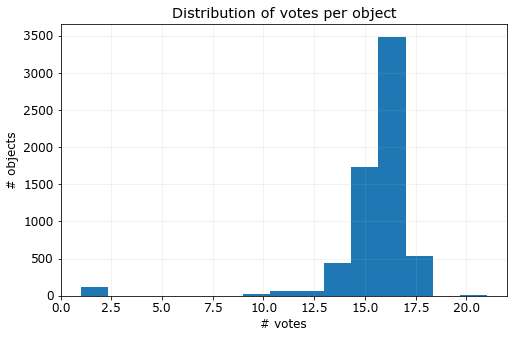

In [25]:
fig, fr = plt.subplots(figsize=(8,5))

fr.hist(vote_counts, bins=15)
fr.grid(alpha=0.2, which='both')
fr.update({
    'xlabel': '# votes',
    'ylabel': '# objects',
    'title': 'Distribution of votes per object',
})

plt.show()

- Extract the occurrence rate of every `# votes` value:

In [26]:
def count_dict(entries):
    '''
    @params: entries: list of vals
    @returns: dictionary where the keys are the vals, and the values are the number of times each val occurs in entries
    '''
    count_dict = {}
    
    for key in set(entries):
        count_dict[key] = entries.count(key)
        
    return count_dict

In [27]:
count_dict(vote_counts)  # uncomment to inspect vote count occurrence rate

{1: 110,
 2: 12,
 9: 3,
 10: 16,
 11: 65,
 12: 63,
 13: 86,
 14: 361,
 15: 1735,
 16: 3483,
 17: 496,
 18: 44,
 19: 4,
 20: 3,
 21: 3}

---
---

## Back to inspecting vote distributions.

In [28]:
df_task0 = df_task0[df_task0['# votes'] > 5]

In [29]:
df_task0.sort_values(['% votes Galaxy'], ascending=False)

,name,counts,# votes,% votes Galaxy,% votes Group of objects (Cluster),% votes Something else/empty center
0,UDGcand_1541,{'Galaxy': 15},15,100.0,0.0,0.0
6256,UDGcand_1157,{'Galaxy': 16},16,100.0,0.0,0.0
6244,UDGcand_969,{'Galaxy': 16},16,100.0,0.0,0.0
4858,UDGcand_1850,{'Galaxy': 16},16,100.0,0.0,0.0
2500,UDGcand_2499,{'Galaxy': 17},17,100.0,0.0,0.0
...,...,...,...,...,...,...
1133,UDGcand_3858,"{'Group of objects (Cluster)': 13, 'Something ...",14,0.0,92.9,7.1
563,UDGcand_3944,{'Something else/empty center': 15},15,0.0,0.0,100.0
2162,UDGcand_5665,{'Something else/empty center': 16},16,0.0,0.0,100.0
2172,UDGcand_5149,"{'Something else/empty center': 15, 'Group of ...",16,0.0,6.2,93.8


## Plot vote distributions

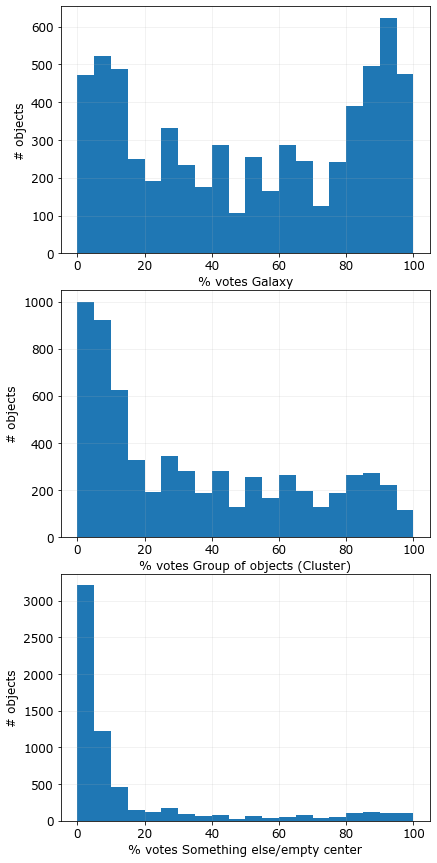

In [30]:
fields = ['% votes {}'.format(ans) for ans in answer_types]

fig, fr = plt.subplots(len(fields), figsize=(6, 12))
fig.tight_layout()

for idx, field in enumerate(fields):
    fr[idx].hist(df_task0[field], bins=20)

    fr[idx].grid(alpha=0.2, which='both')
    fr[idx].update({
        'xlabel': field,
        'ylabel': '# objects'
    })

Of note: 
- votes for `galaxy` is a relatively two-sided distribution. Most likely are basically either 'definitely not a galaxy' and 'definitely a galaxy'.
    Looking at this distribution, a naive first approximation for 'certainty' in the people's vote might be, say, 75% votes for `galaxy`.
- votes for `cluster` is mostly 'no', but there are still plenty of objects where people do vote for `cluster`
- relatively few objects are supposedly `empty` or `something else`

Examine 'Task 1' results. 
- If task 0 answer is `galaxy`, task 1 asks "Is the galaxy fluffy or is it bright?"

In [31]:
answer_types

['Galaxy', 'Group of objects (Cluster)', 'Something else/empty center']

In [32]:
# find classifications where people voted 'galaxy'
df_galaxy = df[(df['Task0'] == 'Galaxy') & (df['annotations'].map(len) > 1)]

In [33]:
# sanity check: check if 'is the galaxy fluffy or is it bright?' is the only question asked 
#    when people answer 'galaxy' in task 0
# also check which answers are possible
task1_questions = []
task1_values = []

for answer in answer_types[:1]:
    df_filtered = df[(df['Task0'] == answer) & (df['annotations'].map(len) > 1)]
    df_filtered['annotations'].apply(lambda x: task1_questions.append(x[1]['task_label']))
    df_filtered['annotations'].apply(lambda x: task1_values.append(x[1]['value']))
    

set(task1_questions)  # set of all questions asked (turns out, it's only the one above)
set(task1_values)     # set of all answers. 
                      # note this could also be found simply using df_galaxy.groupby(['Task1']).groups.keys()

{'Bright', 'Fluffy', None}

In [34]:
gr_galaxy_task1 = df_galaxy.groupby(['Task1'])

print(df_galaxy.Task1.value_counts())  # count of 'Fluffy' and 'Bright'
print('None:', df_galaxy[df_galaxy['Task1'].isnull()].shape[0])  # count of None, presumably people didn't give an answer in this case

Fluffy    31674
Bright    17974
Name: Task1, dtype: int64
None: 755


---

## Plot % votes galaxy vs. % fluffy/bright

In [35]:
galaxy_names = df_galaxy['Filename']

galaxy_task1_values = []

for name in set(galaxy_names):
    group = gr_by_name.get_group(name)        # get all classifications of this object from df
    group = group[group['Task0'] == 'Galaxy'] # select only rows where task0 was answered with 'galaxy'
    
#     rowObj = count_dict(list(group['Task1']))  # create occurence dictionary of answer
    
    rowObj = {}
    for answer in ['Fluffy', 'Bright']:
        rowObj['% {}'.format(answer)] = round(list(group['Task1']).count(answer)*100/group.shape[0], 1)
    
    rowObj['% None'] = group[group['Task1'].isnull()].shape[0]  # manually add 'None' row since None is parsed to NaN otherwise
    rowObj['name'] = name[:-9]  # add object's name to rowObj
    
    galaxy_task1_values.append(rowObj)  # append rowObj to list

# galaxy_task1_values

In [36]:
df_task1 = pd.DataFrame(galaxy_task1_values)

df_tasks = df_task1.merge(df_task0, on='name', how='outer')

In [37]:
has_galaxy_votes = df_tasks[df_tasks['% votes Galaxy'] > 0]
has_galaxy_votes.head()

,% Fluffy,% Bright,% None,name,counts,# votes,% votes Galaxy,% votes Group of objects (Cluster),% votes Something else/empty center
0,100.0,0.0,0.0,UDGcand_2649,"{'Something else/empty center': 6, 'Group of o...",15.0,26.7,33.3,40.0
1,16.7,75.0,1.0,UDGcand_993,"{'Galaxy': 12, 'Something else/empty center': ...",15.0,80.0,6.7,13.3
2,100.0,0.0,0.0,UDGcand_3128,"{'Galaxy': 7, 'Group of objects (Cluster)': 5,...",13.0,53.8,38.5,7.7
3,85.7,14.3,0.0,UDGcand_579,"{'Group of objects (Cluster)': 8, 'Galaxy': 7}",15.0,46.7,53.3,0.0
4,63.6,27.3,1.0,UDGcand_2010,"{'Galaxy': 11, 'Group of objects (Cluster)': 3}",14.0,78.6,21.4,0.0


- Inspect the percentage of votes for 'bright' as function of how many people voted 'galaxy' on the object to begin with. Do this to see if possibly people more more often vote for 'galaxy' on objects they consider bright, for example

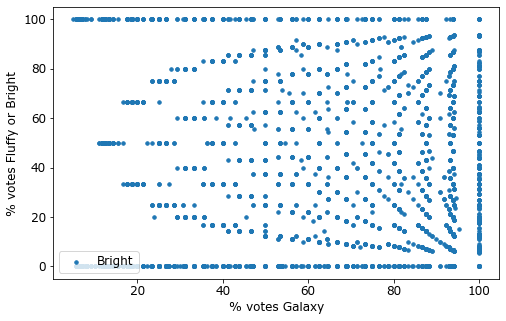

In [38]:
fig, fr = plt.subplots(figsize=(8,5))

fr.scatter(has_galaxy_votes['% votes Galaxy'], has_galaxy_votes['% Bright'], s=12, label='Bright')

fr.update({
    'xlabel': '% votes Galaxy',
    'ylabel': '% votes Fluffy or Bright'
})

fr.legend(loc='lower left')
plt.show()

Looks fairly symmetric about y=50%, so presumably no correlation here.

---
---

## Inspect the votes for objects that are in the post-selection catalogue:

In [39]:
# extract object names from catalogue
catalogue = np.loadtxt('../catalogue/sf_catalogue_targets.txt', dtype='str')

In [40]:
# filter df_tasks to only contain objects in the catalogue
in_catalogue = df_tasks[df_tasks['name'].isin(catalogue)]
not_in_catalogue = df_tasks[~df_tasks['name'].isin(catalogue)]

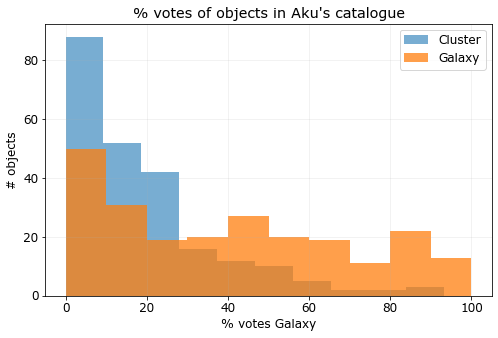

In [41]:
# plot histograms of vote distribution for the objects in the catalogue
fig, fr = plt.subplots(figsize=(8,5))

fr.hist(in_catalogue['% votes Group of objects (Cluster)'], alpha=0.6, label='Cluster')
fr.hist(in_catalogue['% votes Galaxy'], alpha=0.75, label='Galaxy')

fr.update({
    'xlabel': '% votes Galaxy',
    'ylabel': '# objects',
    'title': "% votes of objects in Aku's catalogue"
})
fr.grid(alpha=0.2, which='both')
fr.legend()
plt.show()

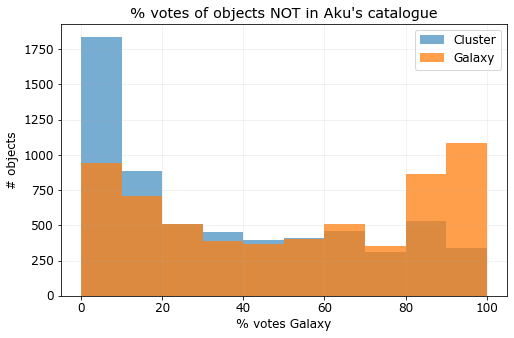

In [42]:
# plot histograms of vote distribution for the objects NOT in the catalogue
fig, fr = plt.subplots(figsize=(8,5))

fr.hist(not_in_catalogue['% votes Group of objects (Cluster)'], alpha=0.6, label='Cluster')
fr.hist(not_in_catalogue['% votes Galaxy'], alpha=0.75, label='Galaxy')

fr.update({
    'xlabel': '% votes Galaxy',
    'ylabel': '# objects',
    'title': "% votes of objects NOT in Aku's catalogue"
})
fr.grid(alpha=0.2, which='both')
fr.legend()
plt.show()

In [43]:
# list of objects both in catalogue and raw dataframe
in_catalogue_and_spacefluff = list(set(catalogue) & set(df['Filename'].apply(lambda x: x[:-9])))

# list of objects in raw dataframe, not in df_tasks
_names_df = set(df['Filename'].apply(lambda x: x[:-9]))
_names_df_tasks = set(df_tasks['name'])

difference = []
for name in _names_df:
    if not name in _names_df_tasks:
        difference.append(name)

# filter df to see the objects that didn't make it into df_tasks, but are in raw df
# df[df['Filename'].apply(lambda x: x[:-9]).isin(difference)]  # uncomment to inspect

---
---

In [44]:
# read csv with object info, which was extracted from the catalogue (without selection cuts)
object_info = pd.read_csv('../catalogue/sf_spacefluff_object_data.csv', comment="#")

object_info.columns

Index(['name', 'RA', 'DEC', 'Reff', 'r_mag', 'g_mag', 'axis_ratio',
       'pos_angle', 'n', 'u', 'g', 'r', 'i', 'ue', 'ge', 're', 'ie', 'Reffe',
       'r_mage', 'ne', 'C', 'mue_r', 'bae', 'RFF'],
      dtype='object')

In [45]:
# merge properties onto dataframe
df_tasks_with_props = df_tasks.merge(object_info, how='outer', on='name')

# filter out objects without actual votes
df_tasks_with_props = df_tasks_with_props[~df_tasks_with_props['# votes'].isnull()]

In [46]:
df_tasks_with_props[df_tasks_with_props['name'].isin(in_catalogue_and_spacefluff)]

,% Fluffy,% Bright,% None,name,counts,# votes,% votes Galaxy,% votes Group of objects (Cluster),% votes Something else/empty center,RA,...,ge,re,ie,Reffe,r_mage,ne,C,mue_r,bae,RFF
5,100.0,0.0,0.0,UDGcand_3465,"{'Something else/empty center': 9, 'Galaxy': 5...",16.0,31.2,12.5,56.2,56.252071,...,0.296976,0.190112,0.129618,1.938340,0.497326,0.331580,3.184110,26.073706,0.075575,-99.0
96,100.0,0.0,0.0,UDGcand_6621,"{'Galaxy': 12, 'Something else/empty center': ...",17.0,70.6,11.8,17.6,54.517124,...,0.054034,0.047986,0.044375,0.256905,0.133476,0.118639,2.385606,23.615711,0.027659,-99.0
107,100.0,0.0,0.0,UDGcand_2735,"{'Galaxy': 15, 'Something else/empty center': 1}",16.0,93.8,0.0,6.2,56.479454,...,0.081486,0.058988,0.049644,0.489458,0.201890,0.163928,2.931329,24.388996,0.037947,-99.0
119,100.0,0.0,0.0,UDGcand_2592,"{'Group of objects (Cluster)': 7, 'Galaxy': 6,...",15.0,40.0,46.7,13.3,52.964294,...,0.149537,0.094005,0.069102,0.777780,0.293686,0.219704,2.532881,25.089375,0.050531,-99.0
134,100.0,0.0,0.0,UDGcand_1702,"{'Something else/empty center': 11, 'Galaxy': ...",16.0,18.8,12.5,68.8,50.856792,...,0.130025,0.109823,0.089689,0.791440,0.313959,0.231468,2.385606,25.214119,0.053176,-99.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6346,NaN,NaN,NaN,UDGcand_6457,"{'Something else/empty center': 14, 'Group of ...",16.0,0.0,12.5,87.5,55.077614,...,0.356866,0.238301,0.215258,3.627467,0.623958,0.395883,2.914625,26.497606,0.089880,-99.0
6377,NaN,NaN,NaN,UDGcand_3779,"{'Something else/empty center': 15, 'Group of ...",16.0,0.0,6.2,93.8,54.887302,...,0.464883,0.275343,0.492124,1.514738,0.618220,0.393035,2.385606,26.480339,0.089247,-99.0
6393,NaN,NaN,NaN,UDGcand_6086,"{'Something else/empty center': 13, 'Group of ...",15.0,0.0,13.3,86.7,57.652386,...,0.221269,0.123539,0.132188,0.829612,0.365684,0.260762,2.385606,25.499113,0.059749,-99.0
6403,NaN,NaN,NaN,UDGcand_378,"{'Something else/empty center': 8, 'Group of o...",11.0,0.0,27.3,72.7,56.409840,...,0.195701,0.120930,0.117776,1.426114,0.387644,0.272920,2.385606,25.608091,0.062472,-99.0
